In [1]:
import json
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Markdown
from PIL import Image

from stackexp import openai_util
from stackexp.export_comments import OUTPUT_PATH as COMMENT__PATH, load_comments_json, TAGS_PATH as COMMENT_TAGS_PATH
from stackexp.nb_config import nb_config
from stackexp.openai_util import PROMPT_CACHE
from stackexp.util import DATA_DIR

IN_A_HURRY_TODAY_ARE_WE = False # nope: shouldn't need to be in a hurry

SELECTED_TAGS_PATH = DATA_DIR / 'substack_tags_select.csv'

nb_config()
embedding_cache = openai_util.EmbeddingCache()

CHAT_COMPLETE_MODEL = "gpt-4o"
EMBEDDING_MODEL = 'text-embedding-3-small'

In [2]:
comments_json = load_comments_json(COMMENT__PATH)
print(len(comments_json))
comments_json[-1]

1306


{'post_id': 163506232,
 'title': 'Tuesday thread',
 'canonical_url': 'https://www.slowboring.com/p/tuesday-thread-97c',
 'name': 'Matt Hagy',
 'user_id': 3094604,
 'reaction': False,
 'id': 116910319,
 'top_level': True,
 'date': 'May 13 2025 17:06',
 'likes': 0,
 'timestamp': 1747170404,
 'body': [[{'type': 'text',
    'value': 'Found some interesting stuff on my X-Tech Report for today while figuring out some ad networking technologies market stuff'}],
  [{'type': 'url',
    'value': 'https://x.com/MarioNawfal/status/1922219688609681511'}],
  [{'type': 'text',
    'value': '> 🇺🇸 ELON’S TUNNEL COMPANY JUST HIT A ROBOT DIGGING MILESTONE — NO HUMANS NEEDED (EXCEPT THE GUY WITH THE CAMERA)'}],
  [{'type': 'text',
    'value': 'And I guess even any Substack can always find "Five charts to help you understand tariffs and shortages" in any '},
   {'type': 'url', 'value': 'https://www.bloomberg.com/oddlots'},
   {'type': 'text',
    'value': " like info product while we're all globally stabi

In [3]:
def construct_comment(paragraphs: list[list[dict[str, Any]]]) -> str:
    return '\n\n'.join(' '.join(l['value'] for l in p if l['type'] == 'text')
                       for p in paragraphs)


comments = pd.DataFrame(comments_json)
comments = comments.set_index('id')
comments['body'] = comments['body'].map(construct_comment)
comments['word_count'] = comments['body'].map(openai_util.count_words)
comments['token_count'] = comments['body'].map(openai_util.count_tokens)
comments

,post_id,title,canonical_url,name,user_id,reaction,top_level,date,likes,timestamp,...,parent_children,thread_id,thread_children,ratio_recv,ratio_give,grade_level,word_count,category,tags,token_count
id,,,,,,,,,,,,,,,,,,,,,
3305267,42751863,Dave Chappelle and the still-doomed politics o...,https://www.slowboring.com/p/dave-chappelle-an...,Matt Hagy,3094604,False,False,Oct 20 2021 13:28,8,1634750923,...,18.0,3301076,18,-6.0,-3.0,10.3,188,Challenges in Regulating Digital Content and C...,"[business strategy, censorship, media influenc...",240
3487721,43514326,Thoughts on the Virginia election,https://www.noahpinion.blog/p/thoughts-on-the-...,Matt Hagy,3094604,False,False,Nov 04 2021 07:40,1,1636026050,...,3.0,3485207,3,NaN,-12.0,10.7,208,Democratic Messaging and Internal Divisions,"[Democratic Party, economic inequality, identi...",254
3592608,43776715,European countries have really high taxes,https://www.slowboring.com/p/european-countrie...,Matt Hagy,3094604,False,False,Nov 12 2021 07:32,17,1636720370,...,16.0,3592377,16,-15.0,5.0,5.0,73,"Critiques on Regulation, Leadership, and Econo...","[economic policy, taxation]",115
3644093,43937960,Time to declare victory on stimulating the eco...,https://www.slowboring.com/p/time-to-declare-v...,Matt Hagy,3094604,False,False,Nov 16 2021 15:24,0,1637094259,...,5.0,3642299,5,0.0,-3.0,8.9,249,Uncategorized,"[business strategy, climate change, economic p...",340
3901854,44832459,What is the goal of child care policy?,https://www.slowboring.com/p/what-is-the-goal-...,Matt Hagy,3094604,False,False,Dec 07 2021 05:28,0,1638872898,...,4.0,3891603,6,NaN,-2.0,10.7,134,Uncategorized,"[education reform, labor market]",166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115373390,163086047,Wednesday thread,https://www.slowboring.com/p/wednesday-thread-f4e,Matt Hagy,3094604,False,False,May 07 2025 20:55,1,1746665731,...,4.0,115338466,10,1.0,0.0,8.3,103,Uncategorized,[education reform],131
115377697,163086047,Wednesday thread,https://www.slowboring.com/p/wednesday-thread-f4e,Matt Hagy,3094604,False,False,May 07 2025 21:17,0,1746667052,...,2.0,115338466,10,NaN,-2.0,9.0,186,Uncategorized,"[US politics, economic inequality, economic po...",239
115383402,163086047,Wednesday thread,https://www.slowboring.com/p/wednesday-thread-f4e,Matt Hagy,3094604,False,False,May 07 2025 21:48,0,1746668881,...,4.0,115331445,55,NaN,-26.0,12.0,276,Uncategorized,"[political polarization, public misinformation...",393


In [4]:
best_comments = (
    comments[
        (comments['token_count'].between(75, 100_000))
    ].sort_values('likes', ascending=False)
)
best_comments[['likes', 'word_count', 'token_count', 'body']]

,likes,word_count,token_count,body
id,,,,
10926838,117,108,158,It is noteworthy that all of these effective D...
15195301,102,137,170,I can’t help feeling that a lot of the anti-SA...
10138366,101,434,537,"> I’m not exactly sure why this happened, but ..."
13140414,95,181,214,> But this whole genre of genuine inquiry into...
12198060,84,372,467,"> Stern: First, being a felon in possession is..."
...,...,...,...,...
96871944,0,100,110,"Yes, although we could leverage that different..."
96666189,0,222,284,"No, haven't yet used Claude beyond some progra..."
96561603,0,207,267,"Yes, I agree we can acknowledge both. My conce..."


In [5]:
substack_tags_select = pd.read_csv(SELECTED_TAGS_PATH)
substack_tags_select

,tag,count,in_refined,choose
0,media influence,738.0,True,True
1,public misinformation,608.0,True,True
2,political polarization,468.0,True,True
3,political leadership,420.0,True,True
4,political campaigns,290.0,True,True
...,...,...,...,...
191,tribalism,1.0,False,False
192,violence,1.0,False,False
193,voter ID issues,1.0,False,False
194,warfare tactics,1.0,False,False


In [6]:
selected_tags = substack_tags_select[substack_tags_select['choose']]['tag'].tolist()
print(len(selected_tags))
selected_tags

64


['media influence',
 'public misinformation',
 'political polarization',
 'political leadership',
 'political campaigns',
 'trust in institutions',
 'social justice',
 'economic inequality',
 'censorship',
 'international relations',
 'education inequality',
 'urban development',
 'free speech issues',
 'gender equality',
 'mental health',
 'housing affordability',
 'immigration issues',
 'labor unions',
 'healthcare complexity',
 'digital privacy',
 'authoritarianism',
 'public safety',
 'environmental impact',
 'climate change',
 'criminal justice reform',
 'human rights',
 'voter behavior',
 'corporate accountability',
 'drug policy',
 'economic policy',
 'AI and ethics',
 'US politics',
 'activism',
 'crime and justice',
 'electoral integrity',
 'foreign policy',
 'geopolitical strategy',
 'hate speech',
 'pandemic response',
 'privacy issues',
 'public health',
 'racial equality',
 'racial policy',
 'religious freedom',
 'renewable energy',
 'social media influence',
 'technology 

In [7]:
selected_tags_comments = []
for i, (_, comment) in enumerate(best_comments.iterrows()):
    print(f'comment {i}')
    tag_comment_response = PROMPT_CACHE.get_or_create(
        prompt_rel_path=Path('tag_comment/v0.txt'),
        cache_key=f'comment_{comment.name}',
        template_values=dict(tags=json.dumps(selected_tags), comment=comment['body']),
        run_prompt_kwds=dict(response_format={"type": "json_object"}),
        cache_suffix='json'
    )
    tag_comment = json.loads(tag_comment_response)
    tag_comment['id'] = comment.name
    selected_tags_comments.append(tag_comment)
selected_tags_comments = pd.DataFrame(selected_tags_comments).set_index('id')
selected_tags_comments

comment 0
comment 1
comment 2
comment 3
comment 4
comment 5
comment 6
comment 7
comment 8
comment 9
comment 10
comment 11
comment 12
comment 13
comment 14
comment 15
comment 16
comment 17
comment 18
comment 19
comment 20
comment 21
comment 22
comment 23
comment 24
comment 25
comment 26
comment 27
comment 28
comment 29
comment 30
comment 31
comment 32
comment 33
comment 34
comment 35
comment 36
comment 37
comment 38
comment 39
comment 40
comment 41
comment 42
comment 43
comment 44
comment 45
comment 46
comment 47
comment 48
comment 49
comment 50
comment 51
comment 52
comment 53
comment 54
comment 55
comment 56
comment 57
comment 58
comment 59
comment 60
comment 61
comment 62
comment 63
comment 64
comment 65
comment 66
comment 67
comment 68
comment 69
comment 70
comment 71
comment 72
comment 73
comment 74
comment 75
comment 76
comment 77
comment 78
comment 79
comment 80
comment 81
comment 82
comment 83
comment 84
comment 85
comment 86
comment 87
comment 88
comment 89
comment 90
comment 9

,tags,residual_tags
id,,
10926838,"[political campaigns, voter behavior, public m...","[messaging strategy, popularism, political com..."
15195301,"[education inequality, economic inequality, so...","[standardized testing, college admissions, edu..."
10138366,"[economic policy, technology ethics, labor uni...","[Silicon Valley trends, tech industry dynamics..."
13140414,"[public misinformation, political polarization...","[political compromise, public opinion, plurali..."
12198060,"[gun control, social justice, criminal justice...","[second amendment, justice system, activist co..."
...,...,...
96871944,"[education reform, education inequality]","[charter schools, teacher recruitment, advance..."
96666189,"[media influence, public misinformation, trust...","[vaccine skepticism, narrative control, myth d..."
96561603,"[political polarization, media influence, vote...","[Elon Musk, electoral strategy, narrative fram..."


In [8]:
selected_apply_tag_counts = pd.Series([
    tag
    for tags in selected_tags_comments['tags']
    for tag in tags
]).value_counts()
selected_apply_tag_counts

media influence              361
economic policy              335
US politics                  258
political polarization       191
political leadership         183
                            ... 
automation                     1
public employment              1
pension reform                 1
government accountability      1
gun ownership                  1
Name: count, Length: 192, dtype: int64

<Axes: >

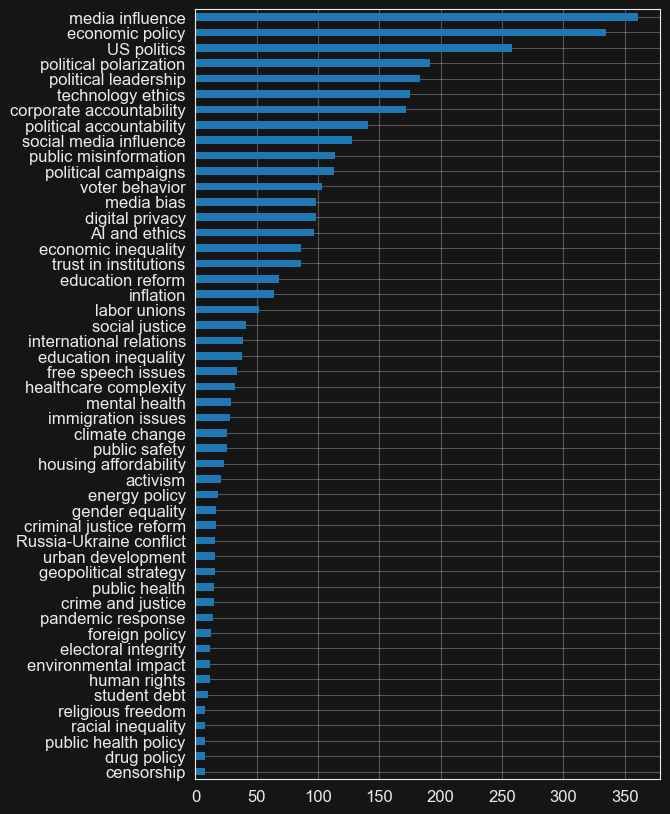

In [9]:
selected_apply_tag_counts.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

In [10]:
residual_apply_tag_counts = pd.Series([
    tag
    for tags in selected_tags_comments['residual_tags']
    for tag in tags
]).value_counts()
residual_apply_tag_counts

Elon Musk                27
fiscal policy            23
tax policy               23
financial crisis         20
monetary policy          19
                         ..
manufacturing             1
public investment         1
healthcare innovation     1
political movements       1
trade policies            1
Name: count, Length: 2157, dtype: int64

<Axes: >

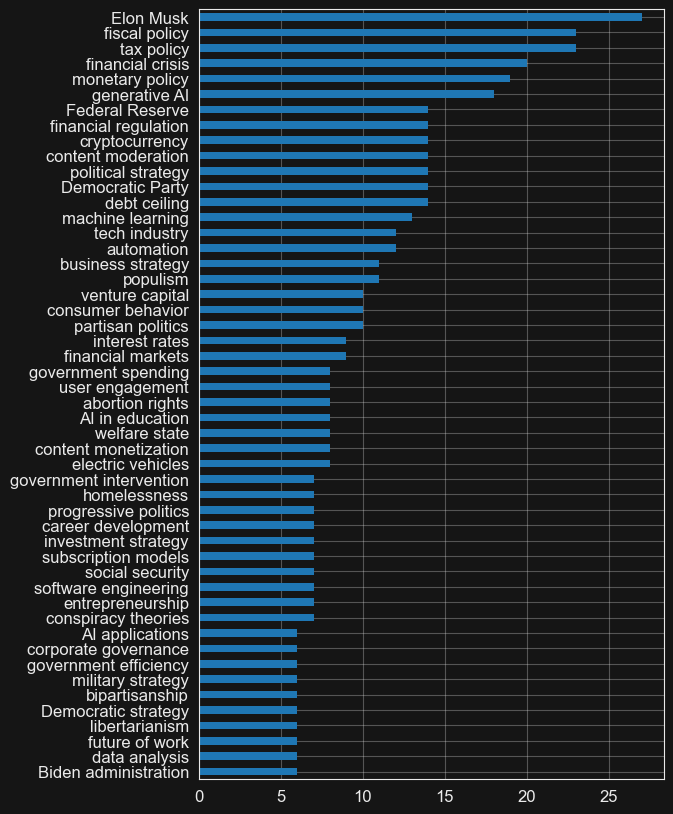

In [11]:
residual_apply_tag_counts.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

In [12]:
all_tags_count = selected_apply_tag_counts.add(residual_apply_tag_counts, fill_value=0).astype(int).sort_values(
    ascending=False)
all_tags_count

media influence           361
economic policy           339
US politics               259
political polarization    191
political leadership      183
                         ... 
emotional intelligence      1
emotional impact            1
emergent behavior           1
email management            1
zoning reform               1
Name: count, Length: 2281, dtype: int64

<Axes: >

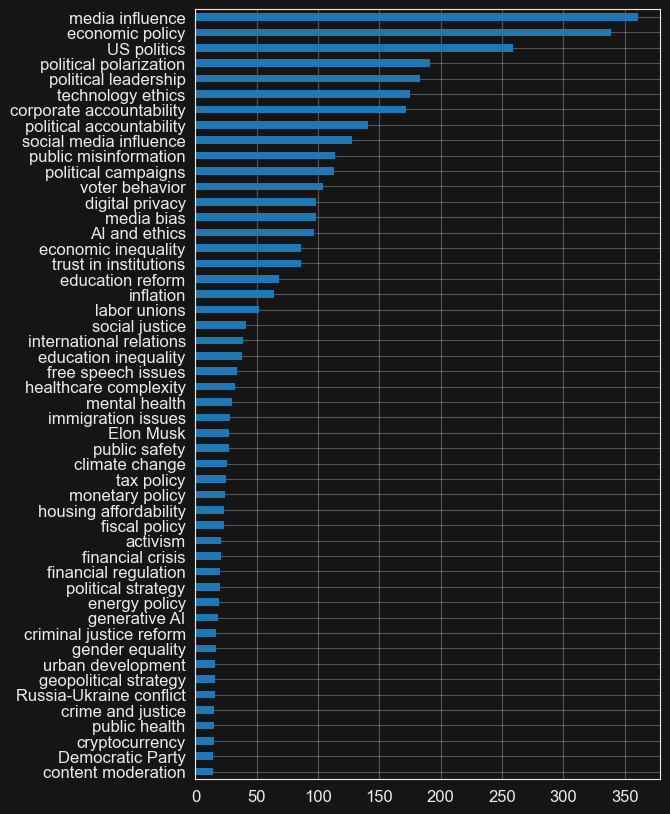

In [13]:
all_tags_count.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

In [14]:
selected_tags_comments_aug = pd.DataFrame([
    dict(id=i, tag=tag)
    for i, tags in selected_tags_comments['tags'].items()
    for tag in tags
])
selected_tags_comments_aug = pd.merge(
    selected_tags_comments_aug,
    comments,
    left_on='id',
    right_index=True,
    how='left'
)
selected_tags_comments_aug

,id,tag,post_id,title,canonical_url,name,user_id,reaction,top_level,date,...,parent_children,thread_id,thread_children,ratio_recv,ratio_give,grade_level,word_count,category,tags,token_count
0,10926838,political campaigns,88097777,A lot of the best political messages are reall...,https://www.slowboring.com/p/a-lot-of-the-best...,Matt Hagy,3094604,False,True,Dec 05 2022 06:29,...,NaN,10926838,19,-94.0,NaN,12.7,108,Democratic Messaging and Internal Divisions,"[Democratic Party, identity politics, populism]",158
1,10926838,voter behavior,88097777,A lot of the best political messages are reall...,https://www.slowboring.com/p/a-lot-of-the-best...,Matt Hagy,3094604,False,True,Dec 05 2022 06:29,...,NaN,10926838,19,-94.0,NaN,12.7,108,Democratic Messaging and Internal Divisions,"[Democratic Party, identity politics, populism]",158
2,10926838,public misinformation,88097777,A lot of the best political messages are reall...,https://www.slowboring.com/p/a-lot-of-the-best...,Matt Hagy,3094604,False,True,Dec 05 2022 06:29,...,NaN,10926838,19,-94.0,NaN,12.7,108,Democratic Messaging and Internal Divisions,"[Democratic Party, identity politics, populism]",158
3,10926838,media influence,88097777,A lot of the best political messages are reall...,https://www.slowboring.com/p/a-lot-of-the-best...,Matt Hagy,3094604,False,True,Dec 05 2022 06:29,...,NaN,10926838,19,-94.0,NaN,12.7,108,Democratic Messaging and Internal Divisions,"[Democratic Party, identity politics, populism]",158
4,15195301,education inequality,115956601,There's no big mystery about why colleges are ...,https://www.slowboring.com/p/sat-optional-affi...,Matt Hagy,3094604,False,True,Apr 25 2023 06:37,...,NaN,15195301,324,-84.0,NaN,14.5,137,Education Reform and Socioeconomic Challenges,"[crime and justice, education inequality, high...",170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,96561603,media influence,157620293,How we’re thinking about covering Donald Trump,https://www.slowboring.com/p/how-were-thinking...,Matt Hagy,3094604,False,False,Feb 27 2025 05:14,...,2.0,96060192,60,NaN,-1.0,10.0,207,Uncategorized,"[Democratic Party, US politics, social media i...",267
3715,96561603,voter behavior,157620293,How we’re thinking about covering Donald Trump,https://www.slowboring.com/p/how-were-thinking...,Matt Hagy,3094604,False,False,Feb 27 2025 05:14,...,2.0,96060192,60,NaN,-1.0,10.0,207,Uncategorized,"[Democratic Party, US politics, social media i...",267
3716,96561603,political campaigns,157620293,How we’re thinking about covering Donald Trump,https://www.slowboring.com/p/how-were-thinking...,Matt Hagy,3094604,False,False,Feb 27 2025 05:14,...,2.0,96060192,60,NaN,-1.0,10.0,207,Uncategorized,"[Democratic Party, US politics, social media i...",267
3717,116910319,technology ethics,163506232,Tuesday thread,https://www.slowboring.com/p/tuesday-thread-97c,Matt Hagy,3094604,False,True,May 13 2025 17:06,...,NaN,116910319,6,12.0,NaN,27.9,69,Uncategorized,"[automation, tech industry]",109


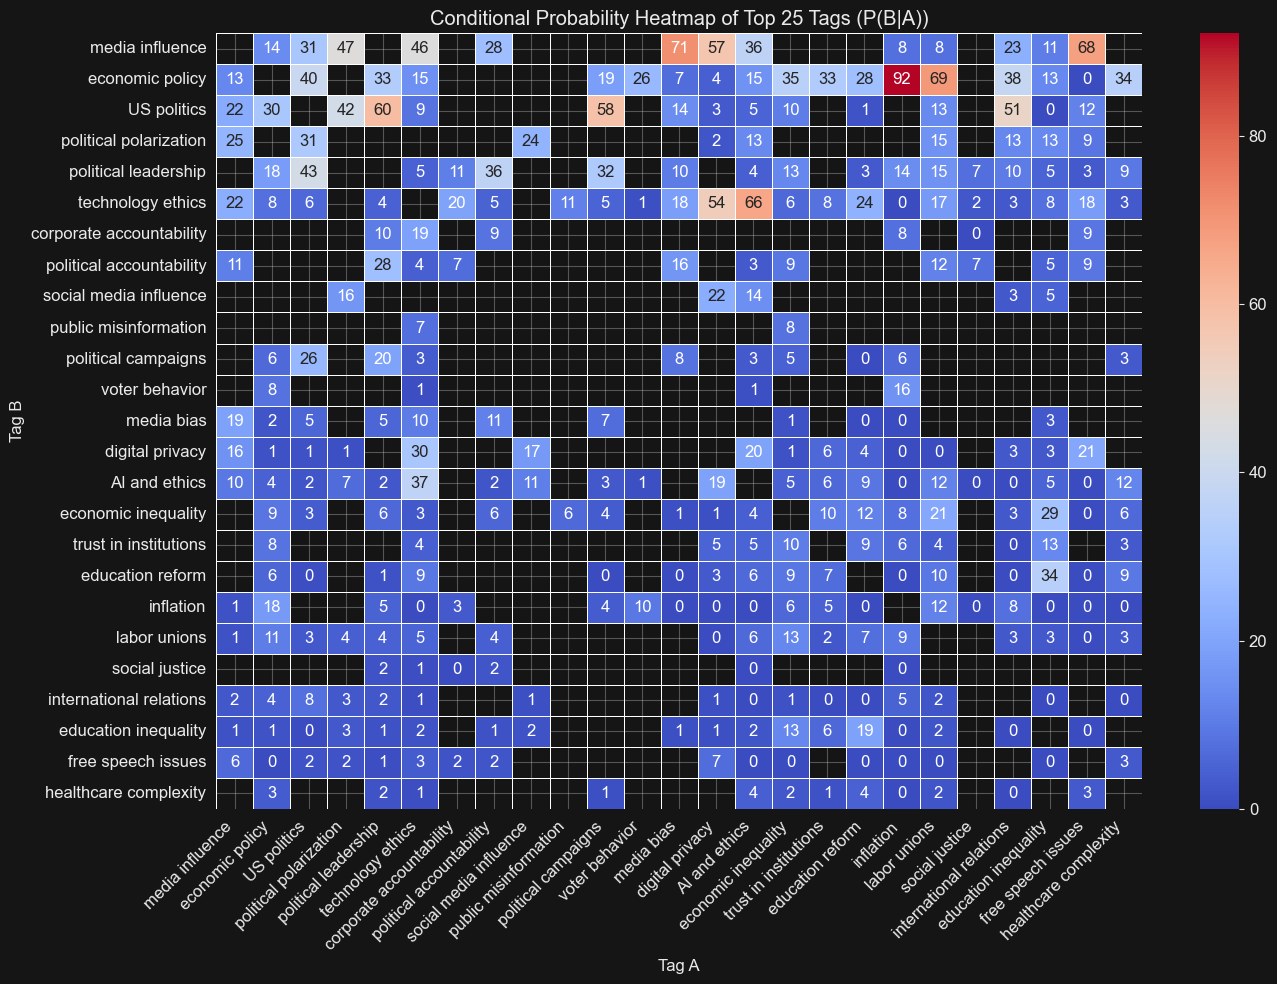

In [15]:
# Step 1: Get the top 25 most frequent tags
top_tags = selected_tags_comments_aug['tag'].value_counts().nlargest(25).index

# Step 2: Filter the dataframe for only the top tags
df_top_tags = selected_tags_comments_aug[selected_tags_comments_aug['tag'].isin(top_tags)]

# Step 3: Create a tag co-occurrence matrix
# Pivot the data to create a binary matrix for tags per id
tag_matrix = df_top_tags.pivot_table(index='id', columns='tag', aggfunc='size', fill_value=0)

# Step 4: Calculate the conditional probability matrix
# Compute the conditional probability P(B|A) where A is on the X-axis and B is on the Y-axis
tag_counts = tag_matrix.T.dot(tag_matrix)
conditional_prob_matrix = tag_counts / tag_matrix.sum(axis=0)

# Step 5: Order tags by frequency
conditional_prob_matrix = conditional_prob_matrix.loc[top_tags, top_tags]

# Step 6: Create a mask to hide the diagonal
mask = np.eye(conditional_prob_matrix.shape[0], dtype=bool) | (tag_counts < 5)

# Step 7: Create a heatmap to visualize the conditional probabilities
plt.figure(figsize=(14, 10))
sns.heatmap(conditional_prob_matrix * 100, annot=True, fmt='.0f', cmap='coolwarm', linewidths=0.5, mask=mask)
plt.title('Conditional Probability Heatmap of Top 25 Tags (P(B|A))')
plt.xlabel('Tag A')
plt.ylabel('Tag B')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display the heatmap
plt.show()


In [16]:
tag_counts

tag,AI and ethics,US politics,corporate accountability,digital privacy,economic inequality,economic policy,education inequality,education reform,free speech issues,healthcare complexity,...,political accountability,political campaigns,political leadership,political polarization,public misinformation,social justice,social media influence,technology ethics,trust in institutions,voter behavior
tag,,,,,,,,,,,,,,,,,,,,,
AI and ethics,97,5,12,19,4,15,2,6,0,4,...,3,3,4,13,5,0,14,64,5,1
US politics,5,258,37,3,9,102,0,1,4,3,...,69,66,110,81,26,0,11,15,14,51
corporate accountability,12,37,172,22,17,94,0,2,3,3,...,12,4,19,4,17,0,9,34,21,3
digital privacy,19,3,22,98,1,4,1,3,7,1,...,0,4,2,2,7,0,22,53,5,0
economic inequality,4,9,17,1,86,30,11,8,0,2,...,8,4,11,9,7,15,6,5,9,5
economic policy,15,102,94,4,30,335,5,19,0,11,...,44,21,60,35,32,6,5,26,28,27
education inequality,2,0,0,1,11,5,38,13,0,1,...,2,1,2,5,2,8,2,3,5,1
education reform,6,1,2,3,8,19,13,68,0,3,...,11,0,2,4,7,6,3,16,6,1
free speech issues,0,4,3,7,0,0,0,0,34,1,...,3,1,1,3,4,0,9,6,4,0


In [17]:
tag_matrix.sum(axis=0)

tag
AI and ethics                97
US politics                 258
corporate accountability    172
digital privacy              98
economic inequality          86
economic policy             335
education inequality         38
education reform             68
free speech issues           34
healthcare complexity        32
inflation                    64
international relations      39
labor unions                 52
media bias                   98
media influence             361
political accountability    141
political campaigns         113
political leadership        183
political polarization      191
public misinformation       114
social justice               41
social media influence      128
technology ethics           175
trust in institutions        86
voter behavior              103
dtype: int64

In [18]:
with COMMENT_TAGS_PATH.open('w') as f:
    json.dump(dict(selected_tags_comments['tags'].sort_index().items()), f, indent=2)

In [19]:
tags_to_define = sorted(all_tags_count.head(200).index)
tags_to_define

['AI advancements',
 'AI and ethics',
 'AI applications',
 'AI in education',
 'Biden administration',
 'Bitcoin',
 'Democratic Party',
 'Democratic strategy',
 'Elon Musk',
 'Federal Reserve',
 'Russia-Ukraine conflict',
 'Tea Party movement',
 'Tesla',
 'Trump administration',
 'US economy',
 'US politics',
 'US-China relations',
 'abortion rights',
 'activism',
 'advertising revenue',
 'algorithmic curation',
 'antitrust issues',
 'authoritarianism',
 'automation',
 'bank regulation',
 'banking crisis',
 'banking industry',
 'banking regulation',
 'billionaire influence',
 'bipartisanship',
 'business strategy',
 'capitalism',
 'career development',
 'censorship',
 'charter schools',
 'class dynamics',
 'climate change',
 'cloud computing',
 'coalition dynamics',
 'comment analysis',
 'community dynamics',
 'community engagement',
 'conspiracy theories',
 'consumer behavior',
 'content creation',
 'content moderation',
 'content monetization',
 'corporate accountability',
 'corporat

In [20]:
if IN_A_HURRY_TODAY_ARE_WE:
    raise 'IN_A_HURRY_TODAY_ARE_WE?'


In [21]:
# can always comment out this cell if we're in a hurry because it commonly takes ~1m30s
# just a reminder that I don't need to run something that is in a different, manually constructed cache
if IN_A_HURRY_TODAY_ARE_WE:
    tags_define_response = '''
    {"tag_definitions":
        [
            {
                "tag": "<Unknown>!warning-could-be-to-random-with-an-f-string-constructed-probabilistically to be longer than the definition associated with it",
                "definition": "This tag is totally unnecessary and ideally nothing is every tagged with it"
            }
        ]
}
'''
else:
    tags_define_response = PROMPT_CACHE.get_or_create(
        prompt_rel_path=Path('tag_define/v0.txt'),
        cache_key=f'tags_to_define',
        template_values=dict(tags=json.dumps(tags_to_define)),
        run_prompt_kwds=dict(response_format={"type": "json_object"}),
        cache_suffix='json'
    )
tag_definitions = pd.DataFrame(json.loads(tags_define_response.strip())['tag_definitions'])
assert set(tag_definitions.columns) == {'tag', 'definition'}, f'columns: {tag_definitions.columns}'
tag_definitions

,tag,definition
0,AI advancements,The latest progress and innovations in artific...
1,AI and ethics,The study of moral principles and issues surro...
2,AI applications,The various uses and implementations of artifi...
3,AI in education,The integration and impact of artificial intel...
4,Biden administration,The executive branch of the United States gove...
...,...,...
189,voter behavior,The patterns and motivations that influence ho...
190,wage growth,"The increase in wages paid to workers, reflect..."
191,wealth inequality,The unequal distribution of assets and wealth ...
192,welfare state,A government that assumes responsibility for t...


In [22]:
(pd.concat([
    all_tags_count.rename('count'),
    tag_definitions.set_index('tag')['definition'],
], axis=1)
 .sort_values('count', ascending=False)
 .to_clipboard(index=True))

In [23]:
selected_defined_tags = pd.read_csv(DATA_DIR / 'Hagy Comment Tag Definitions - 2025-01-01 - Sheet1.csv')
selected_defined_tags = selected_defined_tags[selected_defined_tags['select']].drop(['select'], axis=1)
# selected_defined_tags = selected_defined_tags.head(10)
selected_defined_tags

,tag,count,definition
0,economic policy,284,A course of action taken by a government to in...
1,media influence,255,The impact that media has on shaping public op...
2,US politics,175,"The political activities, events, and policies..."
3,political polarization,156,The process by which political attitudes diver...
8,social media influence,89,The impact that social media platforms and per...
...,...,...,...
173,advertising revenue,3,Income generated from the promotion of product...
175,historical analysis,3,The examination of past events to understand t...
179,right-wing politics,3,Political ideologies and movements that emphas...
181,gun rights,3,The belief in and advocacy for the legal right...


In [24]:
# selected_defined_tags.to_clipboard(index=False)

In [25]:
tag_definitions = selected_defined_tags[['tag', 'definition']].sort_values('tag').reset_index(drop=True)
tag_definitions

,tag,definition
0,Biden administration,The executive branch of the U.S. government un...
1,Democratic Party,One of the two major political parties in the ...
2,Federal Reserve,The central banking system of the United State...
3,Russia-Ukraine conflict,The ongoing geopolitical and military tensions...
4,US politics,"The political activities, events, and policies..."
...,...,...
72,tax policy,Governmental guidelines that dictate how taxes...
73,taxation,The system through which a government raises r...
74,tech industry,"The sector focused on research, development, a..."
75,trust in institutions,The public's confidence in the reliability and...


In [26]:
print(tag_definitions.to_json(orient='records', index=False))

[{"tag":"Biden administration","definition":"The executive branch of the U.S. government under President Joe Biden."},{"tag":"Democratic Party","definition":"One of the two major political parties in the United States, generally associated with liberal policies."},{"tag":"Federal Reserve","definition":"The central banking system of the United States responsible for monetary policy."},{"tag":"Russia-Ukraine conflict","definition":"The ongoing geopolitical and military tensions between Russia and Ukraine."},{"tag":"US politics","definition":"The political activities, events, and policies related to the governance of the United States."},{"tag":"abortion rights","definition":"The belief in or advocacy for the legal right to access abortion services."},{"tag":"activism","definition":"Efforts and actions aimed at promoting, impeding, or directing social, political, or environmental change."},{"tag":"advertising revenue","definition":"Income generated from the promotion of products or servic

In [27]:
defined_tags_comments = []
for i, (_, comment) in enumerate(best_comments.iterrows()):
    print(f'comment {i}')
    tag_comment_response = PROMPT_CACHE.get_or_create(
        prompt_rel_path=Path('tag_comment_defined/v0.txt'),
        cache_key=f'comment_{comment.name}',
        template_values=dict(tag_definitions=tag_definitions.to_json(orient='records', index=False),
                             comment=comment['body']),
        run_prompt_kwds=dict(response_format={"type": "json_object"}),
        cache_suffix='json'
    )
    tag_comment = json.loads(tag_comment_response)
    assert set(tag_comment.keys()) == {'tags'}, f'keys: {tag_comment.keys()}'
    tag_comment['id'] = comment.name
    defined_tags_comments.append(tag_comment)
defined_tags_comments = pd.DataFrame(defined_tags_comments).set_index('id')
defined_tags_comments

comment 0
comment 1
comment 2
comment 3
comment 4
comment 5
comment 6
comment 7
comment 8
comment 9
comment 10
comment 11
comment 12
comment 13
comment 14
comment 15
comment 16
comment 17
comment 18
comment 19
comment 20
comment 21
comment 22
comment 23
comment 24
comment 25
comment 26
comment 27
comment 28
comment 29
comment 30
comment 31
comment 32
comment 33
comment 34
comment 35
comment 36
comment 37
comment 38
comment 39
comment 40
comment 41
comment 42
comment 43
comment 44
comment 45
comment 46
comment 47
comment 48
comment 49
comment 50
comment 51
comment 52
comment 53
comment 54
comment 55
comment 56
comment 57
comment 58
comment 59
comment 60
comment 61
comment 62
comment 63
comment 64
comment 65
comment 66
comment 67
comment 68
comment 69
comment 70
comment 71
comment 72
comment 73
comment 74
comment 75
comment 76
comment 77
comment 78
comment 79
comment 80
comment 81
comment 82
comment 83
comment 84
comment 85
comment 86
comment 87
comment 88
comment 89
comment 90
comment 9

,tags
id,
10926838,"[Democratic Party, populism, identity politics]"
15195301,"[education inequality, crime and justice, high..."
10138366,"[tech industry, labor market, business strateg..."
13140414,"[media influence, public misinformation, polit..."
12198060,"[gun control, gun rights, criminal justice ref..."
...,...
96871944,"[education reform, education inequality]"
96666189,"[public misinformation, media influence, socia..."
96561603,"[Democratic Party, US politics, social media i..."


In [28]:
defined_tag_counts = pd.Series([
    tag
    for tags in defined_tags_comments['tags']
    for tag in tags
]).value_counts()
defined_tag_counts

US politics               261
media influence           177
tech industry             177
economic policy           167
political polarization    151
                         ... 
personal autonomy           1
global ethics               1
moral philosophy            1
healthcare industry         1
financial stability         1
Name: count, Length: 196, dtype: int64

<Axes: >

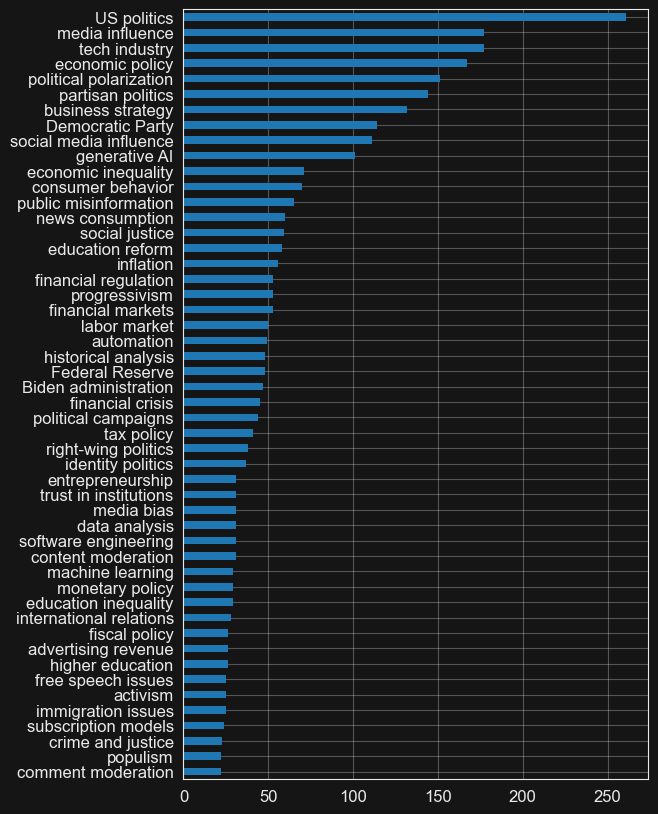

In [29]:
defined_tag_counts.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

<Axes: >

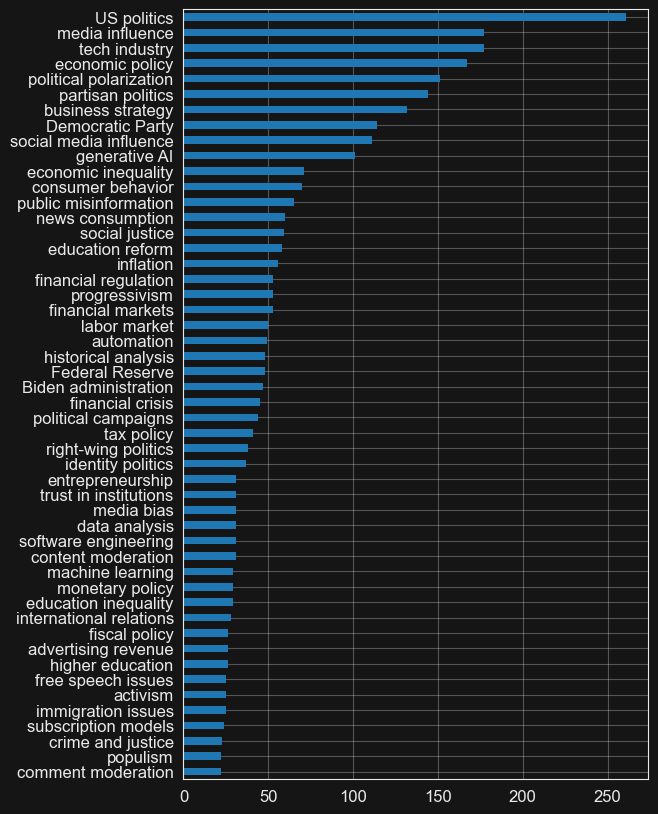

In [30]:
defined_tag_counts_in_given = defined_tag_counts[defined_tag_counts.index.isin(tag_definitions['tag'])]
defined_tag_counts_in_given.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

<Axes: >

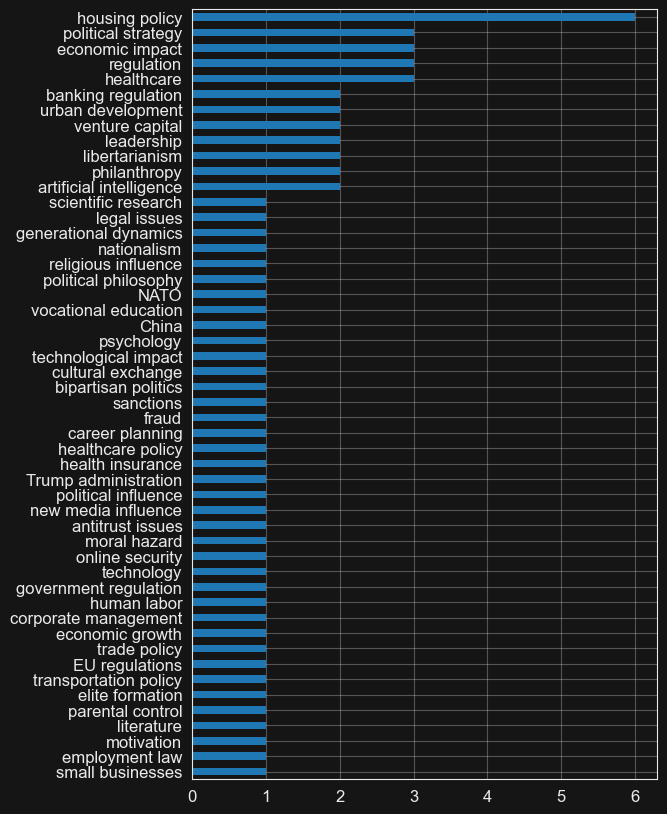

In [31]:
defined_tag_counts_not_in_given = defined_tag_counts[~defined_tag_counts.index.isin(tag_definitions['tag'])]
defined_tag_counts_not_in_given.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

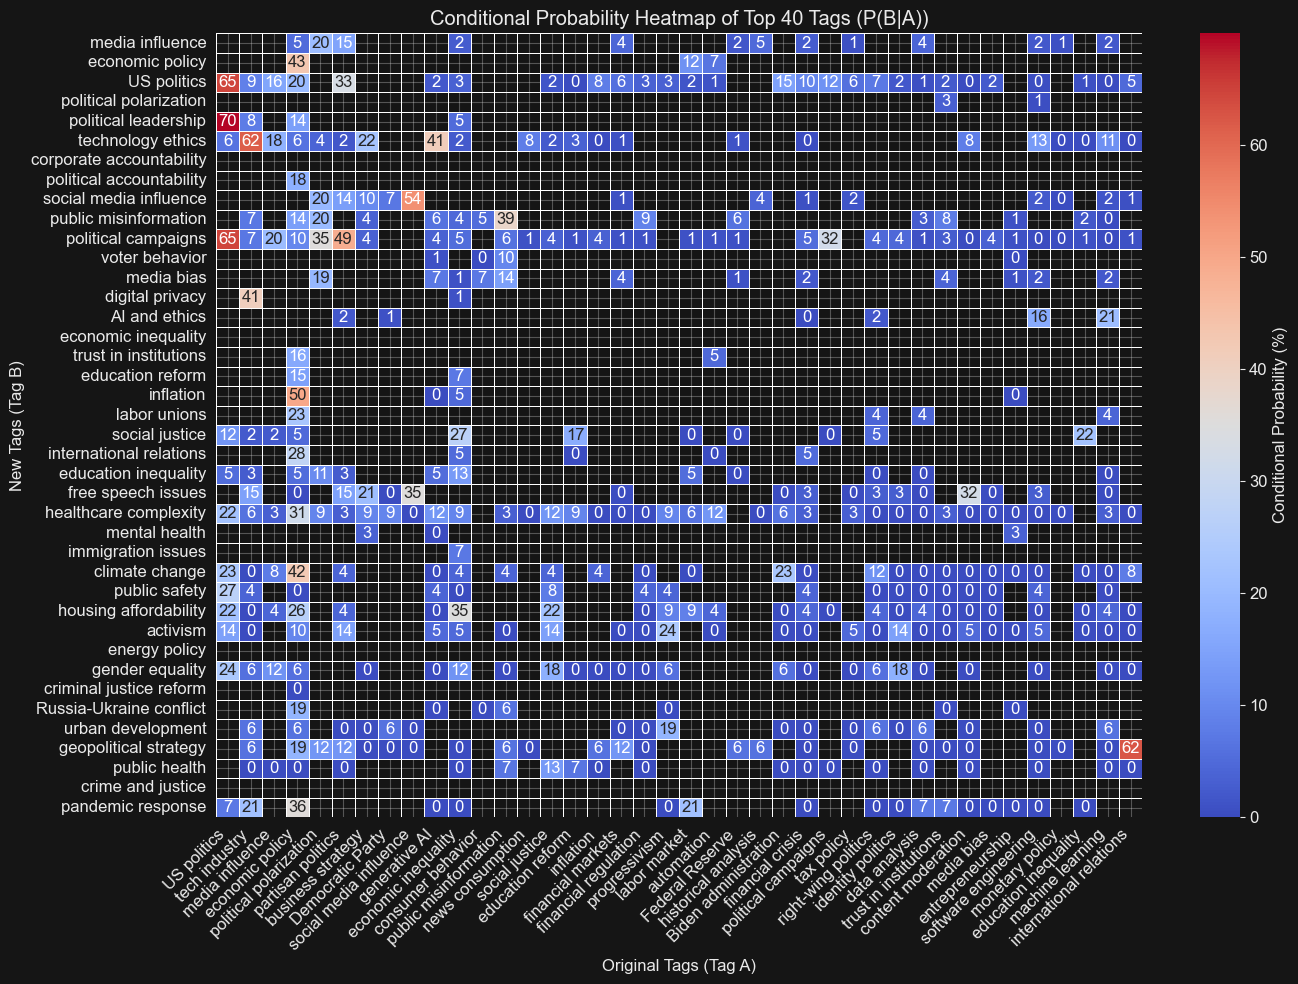

In [32]:
# Step 1: Flatten the tags into DataFrames
n_viz_tags: int = 40

selected_flat = pd.DataFrame(
    [(id_, tag) for id_, tags in selected_tags_comments['tags'].items() for tag in tags],
    columns=['id', 'tag']
)
defined_tags_set = set(tag_definitions['tag'])
defined_flat = pd.DataFrame(
    [(id_, tag) for id_, tags in defined_tags_comments['tags'].items()
     for tag in tags
     if tag in defined_tags_set],
    columns=['id', 'tag']
)

# Step 2: Get the top 25 tags for each group
top_selected_tags = selected_flat['tag'].value_counts().nlargest(n_viz_tags).index
top_defined_tags = defined_flat['tag'].value_counts().nlargest(n_viz_tags).index

# Step 3: Filter the DataFrames for only the top tags
selected_top = selected_flat[selected_flat['tag'].isin(top_selected_tags)]
defined_top = defined_flat[defined_flat['tag'].isin(top_defined_tags)]

# Step 4: Merge the two DataFrames on the "id" column
merged_tags = selected_top.merge(defined_top, on='id', suffixes=('_original', '_defined'), how='inner')

# Step 5: Create a co-occurrence matrix
cooccurrence_matrix = pd.crosstab(
    merged_tags['tag_original'], merged_tags['tag_defined']
)

# Step 6: Calculate the correct normalization denominator
# Group by original tags to count unique IDs per tag
denominator = selected_top.groupby('tag')['id'].nunique()

# Normalize the co-occurrence matrix using the correct denominator
conditional_prob_matrix = cooccurrence_matrix.div(denominator, axis=0)

# Step 7: Reorder rows and columns based on top tags frequency
conditional_prob_matrix = conditional_prob_matrix.loc[top_selected_tags, top_defined_tags]

# Step 8: Create a mask for cells with low counts (<5 occurrences)
mask = cooccurrence_matrix < 5

# Step 9: Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    conditional_prob_matrix * 100,  # Convert probabilities to percentages
    annot=True, fmt='.0f', cmap='coolwarm', linewidths=0.5, mask=mask, cbar_kws={'label': 'Conditional Probability (%)'}
)
plt.title(f'Conditional Probability Heatmap of Top {n_viz_tags} Tags (P(B|A))')
plt.xlabel('Original Tags (Tag A)')
plt.ylabel('New Tags (Tag B)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display the heatmap
plt.show()

<Axes: ylabel='tag'>

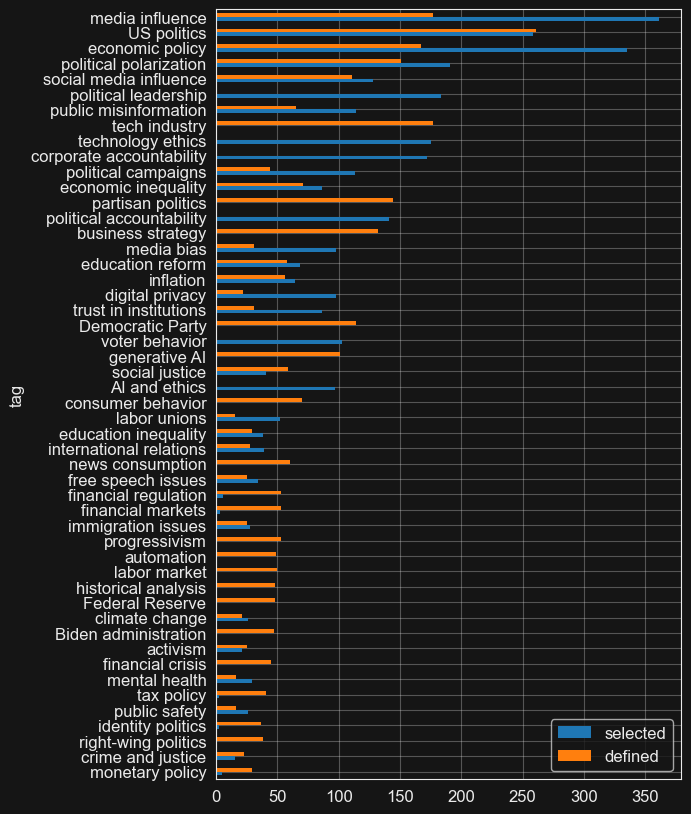

In [33]:
(pd.concat([
    selected_flat['tag'].value_counts(),
    defined_flat['tag'].value_counts(),
], axis=1, keys=['selected', 'defined'])
 .fillna(0).astype(int)
 .assign(total=lambda df: df['selected'] + df['defined'])
 .sort_values('total', ascending=False)
 .head(50)
 .drop(['total'], axis=1)
 .iloc[::-1]
 .plot.barh(figsize=(6, 10))
 )

In [34]:
def select_sort_tags(tags: list[str]) -> list[str]:
    return sorted(tag for tag in tags if tag in defined_tags_set)


with COMMENT_TAGS_PATH.open('w') as f:
    json.dump(dict(defined_tags_comments['tags'].map(select_sort_tags).sort_index().items()), f, indent=2)

In [35]:
defined_tag_counts.head(50)

US politics                261
media influence            177
tech industry              177
economic policy            167
political polarization     151
partisan politics          144
business strategy          132
Democratic Party           114
social media influence     111
generative AI              101
economic inequality         71
consumer behavior           70
public misinformation       65
news consumption            60
social justice              59
education reform            58
inflation                   56
financial regulation        53
progressivism               53
financial markets           53
labor market                50
automation                  49
historical analysis         48
Federal Reserve             48
Biden administration        47
financial crisis            45
political campaigns         44
tax policy                  41
right-wing politics         38
identity politics           37
entrepreneurship            31
trust in institutions       31
media bi

In [36]:
tag = 'comment moderation'
tag_definition, = tag_definitions[tag_definitions["tag"] == tag]["definition"]
print(f'{tag=}: {tag_definition=}')
tag_comments = best_comments[
    best_comments.index.isin(defined_tags_comments[defined_tags_comments['tags']
                             .map(lambda tags: tag in tags)].index)
]
print(f'{len(tag_comments)=}')
top_tag_comments = tag_comments.sort_values('likes', ascending=False).head(150)
print(f'{len(top_tag_comments)=}')
tag_comments_formatted = '\n\n'.join(
    f'Comment {i}:\n{body}'
    for i, body in enumerate(top_tag_comments['body'], 1)
)
# print(tag_comments_formatted)
print(f'{openai_util.count_tokens(tag_comments_formatted)=}')

tag='comment moderation': tag_definition='The practice of reviewing and managing user comments to ensure compliance with community guidelines.'
len(tag_comments)=22
len(top_tag_comments)=22
openai_util.count_tokens(tag_comments_formatted)=4944


In [37]:
summarize_tagged_comments_response = PROMPT_CACHE.get_or_create(
    prompt_rel_path=Path('summarize_tagged_comments/v0.txt'),
    cache_key=f'hagy_{tag}',
    template_values=dict(tag=tag, definition=tag_definition, comments=tag_comments_formatted),
    cache_suffix='md'
)

In [38]:
display(Markdown(summarize_tagged_comments_response))

- **Comment Moderation** is crucial for ensuring compliance with community guidelines.
- Comments can be enhanced by subject-matter experts or hobbyists providing critiques and alternative thoughts.
- Implementing *paywalls* or subscription models can result in higher-quality comments and discussions due to invested interest.
- *High-volume users* often dominate conversations, which could lead to repetitive and less meaningful engagement.
- The ability for authors to choose or customize comment-ranking algorithms could promote diversity and high-quality contributions.
- Using *alternative mediums* for nuanced discussions might prevent unproductive debates in comment sections.
- Technological tools and algorithms can enhance how comments are ranked and curated, potentially learning from systems like Slashdot's comment moderation.

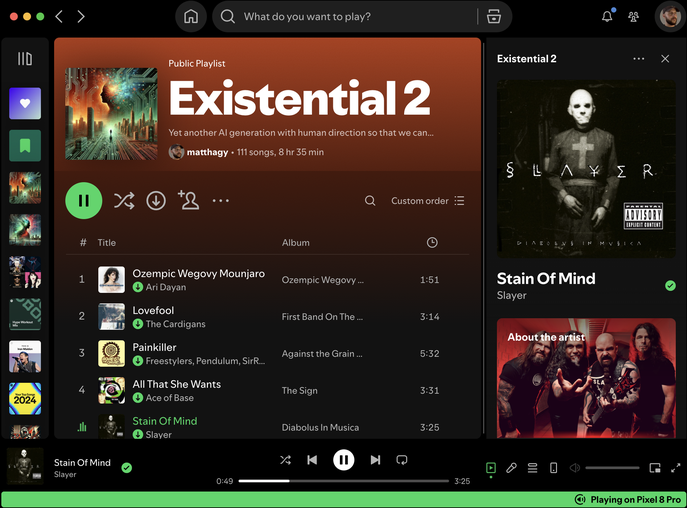

In [39]:
from IPython.display import display
from PIL import Image
from pathlib import Path
import io

img_path = Path("~/Downloads/wip-music.png").expanduser()
img = Image.open(img_path)

scale = 0.33
new_size = (int(scale * img.width), int(scale * img.height))
img_resized = img.resize(new_size, Image.LANCZOS)

buffer = io.BytesIO()
img_resized.save(buffer, format="PNG", optimize=True, compress_level=9)
img_low_res = Image.open(buffer)

display(img_low_res)

In [40]:
img_low_res.save('/tmp/tmp.png')